After importing the appropriate libraries and the train dataset, we can start the exploration.

In [60]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

train=pd.read_csv('train.csv', parse_dates = ['Dates'])
train.head(2)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599


I am initially interested in seeing the range of time that this data spans.

In [78]:
dates = train['Dates']
date_max=dates.max()
date_min = dates.min()
t_delta=(dates-date_min).astype('timedelta64[D]')
train['NumDays']=t_delta
print date_max
print date_min
train.head(1)

2015-05-13 23:53:00
2003-01-06 00:01:00


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,NumDays
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,4510


Now let's have a look at the distribution of crimes by category in the dataset. 

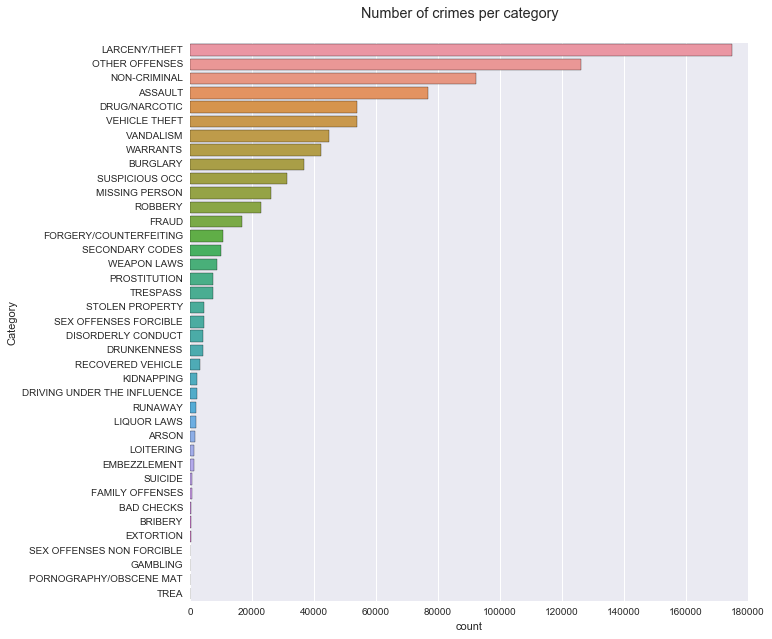

In [80]:
# Set the figure size
f = plt.figure(figsize=(10,10))
# Use the "Category" column from the train dataset and order based on count
sns.countplot(y="Category", data=train, order=train.Category.value_counts().index)
# Set figure title and dims
st = f.suptitle('Number of crimes per category', fontsize="x-large")
st.set_y(0.95)
f.subplots_adjust(top=0.9)
# Save figure as .png
f.savefig('Number of crimes per category.png')

Taking into account the figure above, I am interested in seeing how given "Category" information can be further broken down.

In [85]:
# Count the number of crime "classes" - 39 total
classCount=train.groupby('Category').size().count()
# Now let's see the number of "Descript" - 879 total
descriptCount=train.groupby('Descript').size().count()

Since there are more descriptions than classes, this implies that there are multiple descriptions per class. Looking into "LARCENY/THEFT" we can get the following information about the different descriptions.

In [93]:
# Look into general THEFT column
cat=train[train['Category']=='LARCENY/THEFT']
# Find the count for each description in that column
c=cat['Descript'].value_counts()
# Soft values before rendering
c.sort_values(ascending=False)
c.head(10)

GRAND THEFT FROM LOCKED AUTO      60022
PETTY THEFT FROM LOCKED AUTO      19771
PETTY THEFT OF PROPERTY           16196
GRAND THEFT OF PROPERTY           11010
PETTY THEFT FROM A BUILDING       10029
PETTY THEFT SHOPLIFTING            9571
GRAND THEFT FROM A BUILDING        9512
GRAND THEFT FROM PERSON            7061
GRAND THEFT PICKPOCKET             5653
GRAND THEFT FROM UNLOCKED AUTO     4096
Name: Descript, dtype: int64

There seems to be a lot of theft. Let's zoom into this a bit more. We will first create bins of 30 days of data.

In [126]:
cat['Month']=np.floor(cat['NumDays']/30) # Approximate month (30 day window)

district = "All"

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [111]:
def timeseries(dat,per):
    ''' Category grouped by month '''
    
    # Group by month and district 
    cat_per_time=dat.groupby('Month').Descript.value_counts(sort=True)
    t=cat_per_time.unstack().fillna(0)
        
    # Filter by month per district
    crime_sum=t.sum(axis=0)
    crime_sum.sort_values()
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t[ix.index]
    return t
    
t_all=timeseries(cat,0)
t_all.head(2)

Descript,ATTEMPTED AUTO STRIP,ATTEMPTED GRAND THEFT FROM PERSON,ATTEMPTED GRAND THEFT PICKPOCKET,ATTEMPTED GRAND THEFT PURSESNATCH,ATTEMPTED MOTORCYCLE STRIP,ATTEMPTED PETTY THEFT OF PROPERTY,ATTEMPTED SHOPLIFTING,ATTEMPTED THEFT COIN OPERATED MACHINE,ATTEMPTED THEFT FROM A BUILDING,ATTEMPTED THEFT FROM LOCKED VEHICLE,...,"THEFT, BICYCLE, <$50, SERIAL NUMBER KNOWN","THEFT, BOAT","THEFT, DRUNK ROLL, $200-$400","THEFT, DRUNK ROLL, $50-$200","THEFT, DRUNK ROLL, <$50","THEFT, DRUNK ROLL, >$400","THEFT, GRAND, AGRICULTURAL","THEFT, GRAND, BY FIDUCIARY, >$400 IN 12 MONTHS","THEFT, GRAND, OF FIREARM","TRADE SECRETS, THEFT OR UNAUTHORIZED COPYING"
Month,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,2,4,0,2,25,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,2,4,0,0,48,...,0,0,0,0,0,0,0,0,0,0


In [122]:
# Total incidents per column - and sort by respective number
c = t_all.sum(axis = 0)
c.sort_values(ascending=False).head(5)

Descript
GRAND THEFT FROM LOCKED AUTO    60022
PETTY THEFT FROM LOCKED AUTO    19771
PETTY THEFT OF PROPERTY         16196
GRAND THEFT OF PROPERTY         11010
PETTY THEFT FROM A BUILDING     10029
dtype: float64

After taking a look at a resource I found online, we can group by types of theft incidents into broader groups. First let's list all scenaria. 

In [125]:
c.index

Index([u'ATTEMPTED AUTO STRIP', u'ATTEMPTED GRAND THEFT FROM PERSON',
       u'ATTEMPTED GRAND THEFT PICKPOCKET',
       u'ATTEMPTED GRAND THEFT PURSESNATCH', u'ATTEMPTED MOTORCYCLE STRIP',
       u'ATTEMPTED PETTY THEFT OF PROPERTY', u'ATTEMPTED SHOPLIFTING',
       u'ATTEMPTED THEFT COIN OPERATED MACHINE',
       u'ATTEMPTED THEFT FROM A BUILDING',
       u'ATTEMPTED THEFT FROM LOCKED VEHICLE',
       u'ATTEMPTED THEFT FROM UNLOCKED VEHICLE',
       u'ATTEMPTED THEFT OF A BICYCLE',
       u'EMBEZZLEMENT FROM DEPENDENT OR ELDER ADULT BY CARETAKER',
       u'GRAND THEFT AUTO STRIP', u'GRAND THEFT BICYCLE',
       u'GRAND THEFT BY PROSTITUTE', u'GRAND THEFT COIN OPERATED MACHINE',
       u'GRAND THEFT FROM A BUILDING', u'GRAND THEFT FROM LOCKED AUTO',
       u'GRAND THEFT FROM PERSON', u'GRAND THEFT FROM UNLOCKED AUTO',
       u'GRAND THEFT MOTORCYCLE STRIP', u'GRAND THEFT OF PROPERTY',
       u'GRAND THEFT PHONE BOOTH', u'GRAND THEFT PICKPOCKET',
       u'GRAND THEFT PURSESNATCH', u'GR

In [129]:
auto_grand=['GRAND THEFT FROM LOCKED AUTO',
                    'GRAND THEFT FROM UNLOCKED AUTO',
                    'ATTEMPTED THEFT FROM LOCKED VEHICLE',
                    'ATTEMPTED THEFT FROM UNLOCKED VEHICLE',
                    'GRAND THEFT AUTO STRIP',
                    'ATTEMPTED AUTO STRIP',
                    'GRAND THEFT MOTORCYCLE STRIP']

auto_petty=['PETTY THEFT FROM LOCKED AUTO',
               'PETTY THEFT FROM UNLOCKED AUTO',
               'PETTY THEFT AUTO STRIP']

auto=auto_petty+auto_grand

In additio to cars, we know that people love bikes in SF, therefore:

In [130]:
bike=['GRAND THEFT BICYCLE',
      'PETTY THEFT BICYCLE',
      'ATTEMPTED THEFT OF A BICYCLE',
      'THEFT, BICYCLE, <$50, NO SERIAL NUMBER',
      'THEFT, BICYCLE, <$50, SERIAL NUMBER KNOWN']

In [136]:
building=['GRAND THEFT FROM A BUILDING',
          'PETTY THEFT FROM A BUILDING',
          'ATTEMPTED THEFT FROM A BUILDING']

In [137]:
prop=['GRAND THEFT OF PROPERTY',
              'ATTEMPTED PETTY THEFT OF PROPERTY']

In [133]:
shoplift=['PETTY THEFT SHOPLIFTING',
          'GRAND THEFT SHOPLIFTING',
          'ATTEMPTED SHOPLIFTING']

In [134]:
person=['GRAND THEFT FROM PERSON',
               'GRAND THEFT PICKPOCKET',
               'ATTEMPTED GRAND THEFT FROM PERSON',
               'GRAND THEFT PURSESNATCH',
               'ATTEMPTED GRAND THEFT PURSESNATCH',
               'ATTEMPTED GRAND THEFT PICKPOCKET',
               'ATTEMPTED GRAND THEFT FROM PERSON']

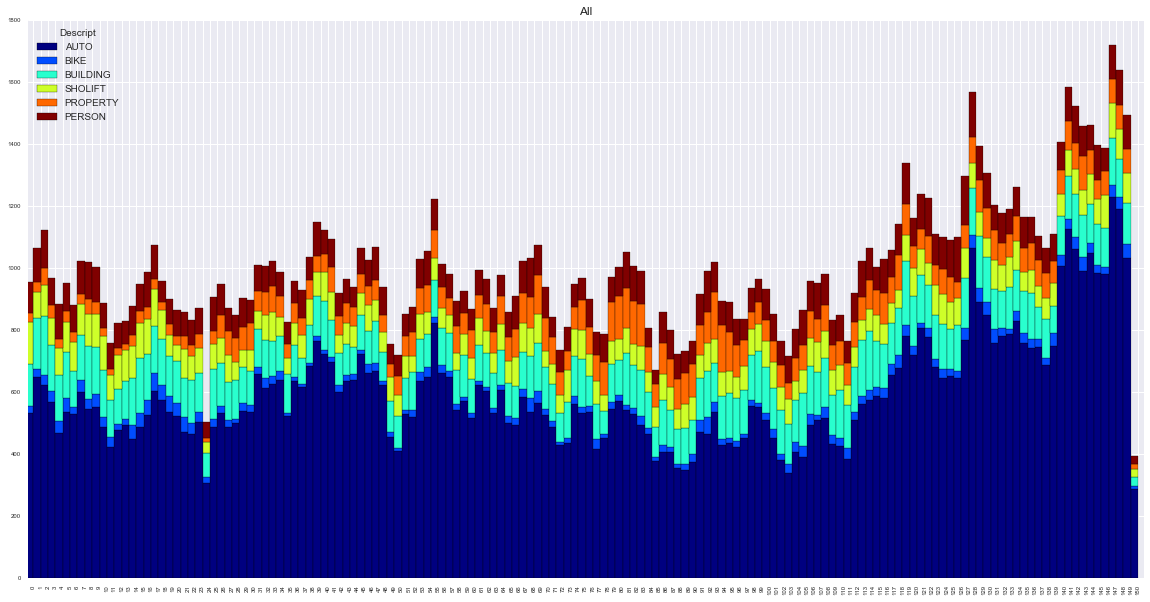

In [153]:
# Lets use real dates for plotting
days_from_start=pd.Series(t_all.index*30).astype('timedelta64[D]')
dates_for_plot=date.min()+days_from_start
time_labels=dates_for_plot.map(lambda x: str(x.year)+'-'+str(x.month))

def theft_analysis(t,district,plot, normal, legendShow):
    t['AUTO']=t[map(lambda s: s.strip(), auto)].sum(axis=1)
    t['BIKE']=t[map(lambda s: s.strip(), bike)].sum(axis=1)
    t['BUILDING']=t[map(lambda s: s.strip(), building)].sum(axis=1)
    t['SHOLIFT']=t[map(lambda s: s.strip(), shoplift)].sum(axis=1)
    t['PROPERTY']=t[map(lambda s: s.strip(), prop)].sum(axis=1)
    t['PERSON']=t[map(lambda s: s.strip(), person)].sum(axis=1)
    theft=t[['AUTO','BIKE','BUILDING','SHOLIFT','PROPERTY','PERSON']]
    if plot:
        if normal:
            theft=theft.div(theft.sum(axis=1),axis=0)
        theft.index=[int(i) for i in theft.index]
        colors = plt.cm.jet(np.linspace(0, 1, theft.shape[1]))
        theft.plot(kind='bar', stacked=True, figsize=(20,10), color=colors, width=1, title=district,fontsize=6, legend=legendShow)
        if normal:
            plt.ylim([0,1])

    return theft

theft_df_all=theft_analysis(t_all,district,True, False, True)

Now let's normalize the data so we can see the effect on a [0,1]-basis axis.

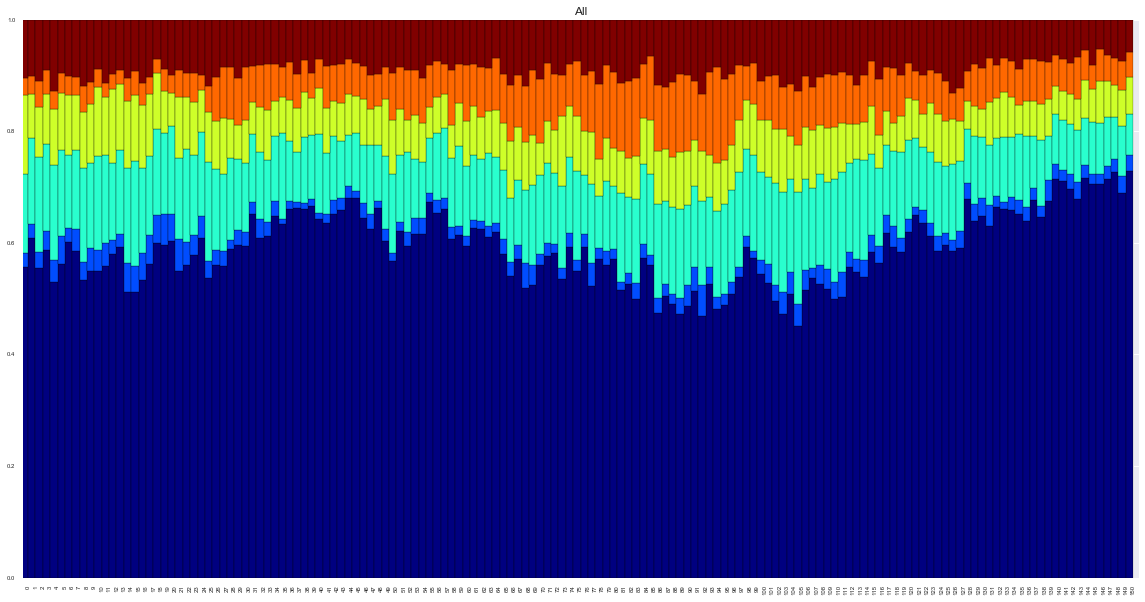

In [154]:
theft_df_all=theft_analysis(t_all,district,True, True, False)

Let's add the real dates, so we see how the actual effects vary throughout the years of data provided.

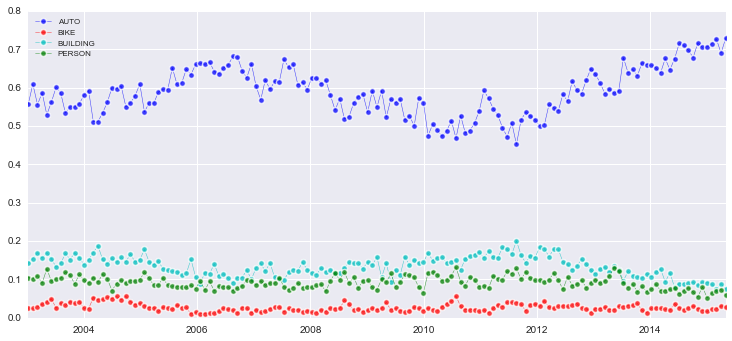

In [155]:
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (12.5,5.5)})
for d,c in zip(['AUTO','BIKE','BUILDING','PERSON'],['b','r','c','g']):
    plt.plot(dates_for_plot.index,theft_df_all[d],'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

Now let's look at the the resolutions that took place.

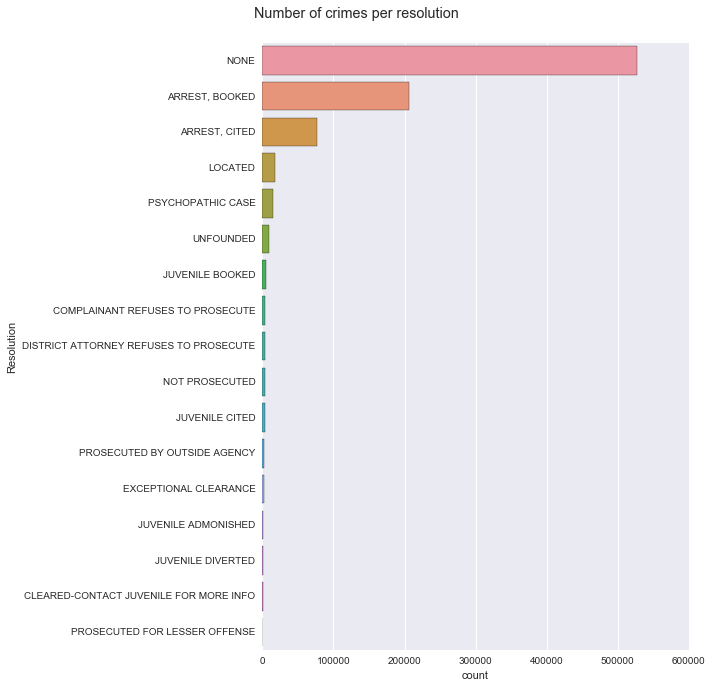

In [12]:
f = plt.figure(figsize=(10,10))
sns.countplot(palette = None, y="Resolution", data=train, order=train.Resolution.value_counts().index)
f.tight_layout()
st = f.suptitle('Number of crimes per resolution', fontsize="x-large")
st.set_y(0.95)
f.subplots_adjust(top=0.9)
f.savefig('Number of crimes per resolution.png')

Since we might soon be interested in viewing how number of crimes vary per district, I was interested in seeing how that would display, as shown below.

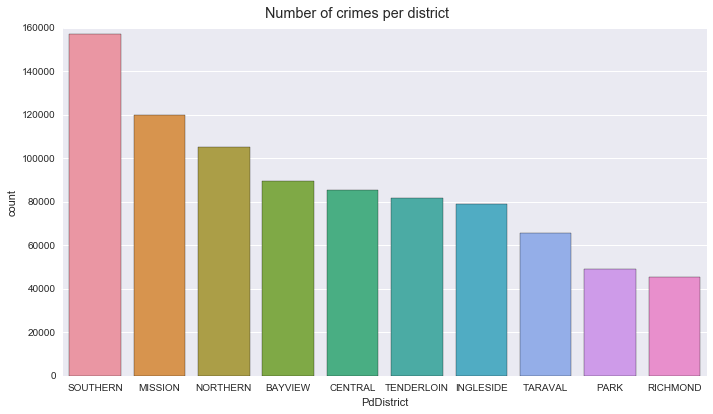

In [13]:
f = plt.figure(figsize=(10,6))
sns.countplot(x="PdDistrict", data=train, order=train.PdDistrict.value_counts().index)
f.tight_layout()
st = f.suptitle('Number of crimes per district', fontsize="x-large")
st.set_y(0.95)
f.subplots_adjust(top=0.9)
f.savefig('Number of crimes per district.png')

Create a array of weekdays, so that we can order accordinly. 

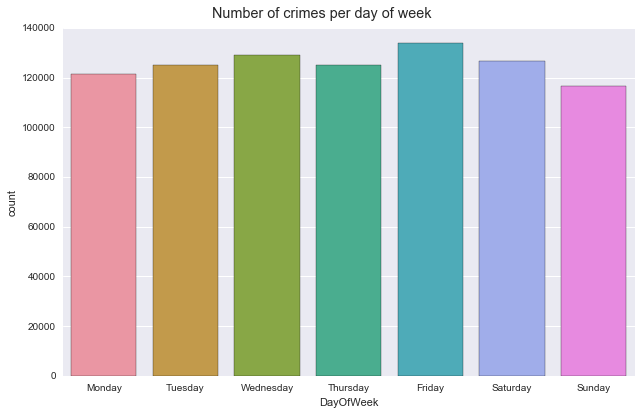

In [14]:
# We could implement the following, but days are not sorted accordingly
# weekDays = train.DayOfWeek.unique()
# Hence, we hardcode the weekdays in an array
weekDays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

f = plt.figure(figsize=(9,6))
sns.countplot(x="DayOfWeek", data=train, order=weekDays)
f.tight_layout()
st = f.suptitle('Number of crimes per day of week', fontsize="x-large")
st.set_y(0.95)
f.subplots_adjust(top=0.9)
f.savefig('Number of crimes per day of week.png')